In [1]:
# -*- coding: utf-8 -*-
# Python 3.12.6

# Internal Libs
import random
import os
from datetime import datetime
now = datetime.now()

# External Libs
import numpy as np
import pandas as pd
## Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Produced Libs:
## Data loader
from scripts.data_loader import DataLoader

## Filters
### Filters for AIS data
from scripts.filters.ais_filters import AISFilters as af, AISInterpolation as ai
### Filters for Norsat data
from scripts.filters.norsat_filters import NorsatFilters as nf
### Filters for SAR data
from scripts.filters.sar_filters import SARFilters as sf
### Filters for matched data
from scripts.filters.matched_filters import MatchedFilters as mf

## Matching algorithms
### Nearest neighbour
from scripts.matchers.nearest_neighbour_matching import NearestNeighbourMatcher as nnm
### Hungarian method
from scripts.matchers.hungarian_algorithm_matching import HungarianAlgorithmMatcher as ham
### Clustering methods
from scripts.matchers.clustering_matching import ClusteringMatcher as cma

## Plotting and understanding
### visualize uncertainty
from scripts.plots.difference_visualizer import DifferenceVisualizer as dv
### Map plotting
#from scripts.plots.map_plots import MapPlots as mp
### Cluster plotting
from scripts.plots.cluster_plot import ClusterPlot as cp

#from scripts.data_formatter import DataProcessor as dp
#from scripts.matching import hungarian_method
#from scripts.plotter import Plotter as pl

In [2]:
# Define date and time filter
date_key = '03-11-2022'

# PATHS, dataframe and shpfile #
# Define paths
base_path = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\"
## File names ##
# AIS
ais_files = {
    '02-11-2022': 'ais\\ais_110215.csv',
    '03-11-2022': 'ais\\ais_110315.csv',
    '05-11-2022': 'ais\\ais_1105.csv'
}
# SAR
sar_files = {
    '02-11-2022': 'sar\\Sentinel_1_detection_20221102T1519.json',
    '03-11-2022': 'sar\\Sentinel_1_detection_20221103T154515.json',
    '05-11-2022': 'sar\\Sentinel_1_detection_20221105T162459.json'
}
# Norsat
norsat_files = {
    '02-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-02T151459Z.json',
    '03-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-03T152759Z.json',
    '05-11-2022': 'norsat\\Norsat3-N1-JSON-Message-DK-2022-11-05T155259Z.json'
}

# LOADING #
data_loader = DataLoader(base_path = base_path, ais_files = ais_files, sar_files = sar_files, norsat_files = norsat_files, date_key = date_key)
ais_loader, sar_loader, norsat_loader = data_loader.load_data()

######### SAR #########
# images by date_key: sar_loader.dfs_sar
# objects by date_key: sar_loader.sar_object_dfs
######### AIS #########
#ais_loader.dfs_ais
######### Norsat #########
#norsat_loader.dfs_norsat

sar_data = sar_loader.sar_object_dfs[date_key].copy()
ais_data = ais_loader.dfs_ais[date_key].copy()
norsat_data = norsat_loader.dfs_norsat[date_key].copy()

AIS Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['ais_id', 'mmsi', 'TimeStamp', 'latitude', 'longitude', 'length',
       'width', 'sog', 'cog', 'source'],
      dtype='object')
Norsat Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['norsat_id', 'TimeStamp', 'latitude', 'longitude',
       'CollectionInformation', 'NRDEmitterPosition', 'CandidateList',
       'source', 'UncertaintyEllipsePoints'],
      dtype='object')
SAR Data Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['ProductType', 'Polarization', 'Swath', 'TimeStamp', 'TimeStamp_end',
       'Name', 'Satellite', 'Shape', 'Objects', 'source'],
      dtype='object')
SAR object Loaded:
dict_keys(['02-11-2022', '03-11-2022', '05-11-2022'])
Columns for the first DataFrame: Index(['sar_id', 'sar_image_id', 'TimeStamp', 'latitude', 'longitude', 'width',
       '

In [3]:
# FILTERING #
# Filter SAR data
## Filter out SAR data based on on_sea
sar_data = sar_data[sar_data['on_sea'] == True] # This is the SAR data that is on sea
## Filter out SAR data based on class 0
filtered_sar_data = sf.filter_sar_probabilities(sar_data) # This is the SAR data that is class 0

# Filter AIS data
## Define the time threshold for comparison
delta_time = pd.Timedelta(hours=1)
## Finding vessels in AIS data that are close to objects in SAR and Norsat
mmsi_ais_sar = af.ais_find_matching_vessels(AIS_data=ais_data, comparison_data=sar_data, delta_time=delta_time) # This is the AIS data that is close to SAR data time
mmsi_ais_norsat = af.ais_find_matching_vessels(AIS_data=ais_data, comparison_data=norsat_data, delta_time=delta_time) # This is the AIS data that is close to Norsat data time
## Filter AIS data by MMSI
filtered_ais_to_sar = af.filter_by_mmsi(mmsi_ais_sar, ais_data) # This is the AIS data by MMSI numbers that are close to SAR data
filtered_ais_to_norsat = af.filter_by_mmsi(mmsi_ais_norsat, ais_data) # This is the AIS data by MMSI numbers that are close to Norsat data

In [4]:
# INTERPOLATION WITH FILTERING #
# Interpolate MMSI points for filtered AIS data to SAR and Norsat
print('Interpolating MMSI points for filtered AIS data to:')
## Interpolate MMSI points for filtered AIS data to SAR
print('SAR')
interpolated_ais_sar, not_enough_sar = ai.ais_interpolate_mmsi_points(filtered_ais_to_sar, sar_data['TimeStamp'])
## Interpolate MMSI points for filtered AIS data to Norsat
print('Norsat')
interpolated_ais_norsat, not_enough_norsat = ai.ais_interpolate_mmsi_points(filtered_ais_to_norsat, norsat_data['TimeStamp'])

# Evaluate the speed over ground between interpolation point and before/after points
## AIS to SAR interpolation dataframe
interpolated_ais_sar = ai.evaluate_sog_between_points(interpolated_ais_sar, 35)
## AIS to Norsat interpolation dataframe
interpolated_ais_norsat = ai.evaluate_sog_between_points(interpolated_ais_norsat, 35)

## Filter out AIS data that has a speed over ground of > 35 knots
### AIS to SAR interpolation dataframe
interpolated_ais_sar = interpolated_ais_sar[
    ~interpolated_ais_sar['exceeds_threshold_before'] & 
    ~interpolated_ais_sar['exceeds_threshold_after']]
### AIS to Norsat interpolation dataframe
interpolated_ais_norsat = interpolated_ais_norsat[
    ~interpolated_ais_norsat['exceeds_threshold_before'] & 
    ~interpolated_ais_norsat['exceeds_threshold_after']]
print('Speed over ground filtering, (SOG > 35 knots):')
print('MMSI numbers with AIS data that do not exceed the SOG threshold for SAR:', len(interpolated_ais_sar.groupby('mmsi')))
print('MMSI numbers with AIS data that do not exceed the SOG threshold for Norsat:', len(interpolated_ais_norsat.groupby('mmsi')))

Interpolating MMSI points for filtered AIS data to:
SAR
MMSI numbers with insufficient data points: 99 out of 2515
Norsat
MMSI numbers with insufficient data points: 98 out of 2520
Speed over ground filtering, (SOG > 35 knots):
MMSI numbers with AIS data that do not exceed the SOG threshold for SAR: 2404
MMSI numbers with AIS data that do not exceed the SOG threshold for Norsat: 2406


In [5]:
## Non clustered matching ##
# NEAREST NEIGHBOUR MATCHING #
nnm_ais_sar = nnm.nearest_neighbour_matching(df1 = interpolated_ais_sar, df2 = filtered_sar_data, id1_col = 'mmsi', id2_col = 'sar_id')
nnm_ais_norsat = nnm.nearest_neighbour_matching(df1 = interpolated_ais_norsat, df2 = norsat_data, id1_col = 'mmsi', id2_col = 'norsat_id')
nnm_sar_norsat = nnm.nearest_neighbour_matching(df1 = filtered_sar_data, df2 = norsat_data, id1_col = 'sar_id', id2_col = 'norsat_id')
NNM = {'ais_sar': nnm_ais_sar, 'ais_norsat': nnm_ais_norsat, 'sar_norsat': nnm_sar_norsat}

# HUNGARIAN METHOD MATCHING #
ham_ais_sar, ais_sar_cost_matrix = ham.hungarian_method_matching(df1 = interpolated_ais_sar, df2 = filtered_sar_data, id1_col = "mmsi", id2_col = "sar_id")
ham_ais_norsat, ais_norsat_cost_matrix = ham.hungarian_method_matching(df1 = interpolated_ais_norsat, df2 = norsat_data,  id1_col = "mmsi", id2_col = "norsat_id")
ham_sar_norsat, sar_norsat_cost_matrix = ham.hungarian_method_matching(df1 = filtered_sar_data, df2 = norsat_data,  id1_col = "sar_id", id2_col = "norsat_id")
HAM = {'ais_sar': ham_ais_sar, 'ais_norsat': ham_ais_norsat, 'sar_norsat': ham_sar_norsat}

In [6]:
## Clustering variables ##
epsilon = 7 # Epsilon for DBSCAN, UNIT: kilometers
min_samples = 2 # Minimum samples for DBSCAN
print('Clustering with epsilon:', epsilon, 'km \n Minimum samples:', min_samples)

Clustering with epsilon: 7 km 
 Minimum samples: 2


In [7]:
# HUNGARIAN METHOD WITH CLUSTERING #
CHAM_ais_sar = cma.HAM_clustering(df1 = interpolated_ais_sar, df2 = filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=epsilon, min_samples=min_samples)
CHAM_ais_norsat = cma.HAM_clustering(df1 = interpolated_ais_norsat, df2 = norsat_data, ids=['mmsi', 'norsat_id'], sources=['ais', 'norsat'], eps=epsilon, min_samples=min_samples)
CHAM_sar_norsat = cma.HAM_clustering(df1 = filtered_sar_data, df2 = norsat_data, ids=['sar_id', 'norsat_id'], sources=['sar', 'norsat'], eps=epsilon, min_samples=min_samples)
CHAM = {'ais_sar': CHAM_ais_sar, 'ais_norsat': CHAM_ais_norsat, 'sar_norsat': CHAM_sar_norsat}

Estimated number of clusters: 241
Estimated number of noise points: 184
Estimated number of clusters: 235
Estimated number of noise points: 192
Estimated number of clusters: 67
Estimated number of noise points: 132


In [8]:
# NEAREST NEIGHBOUR WITH CLUSTERING #
CNNM_ais_sar = cma.NNM_clustering(df1 = interpolated_ais_sar, df2=filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=epsilon, min_samples=min_samples)
CNNM_ais_norsat = cma.NNM_clustering(df1 = interpolated_ais_norsat, df2 = norsat_data, ids=['mmsi', 'norsat_id'], sources=['ais', 'norsat'], eps=epsilon, min_samples=min_samples)
CNNM_sar_norsat = cma.NNM_clustering(df1 = filtered_sar_data, df2 = norsat_data, ids=['sar_id', 'norsat_id'], sources=['sar', 'norsat'], eps=epsilon, min_samples=min_samples)
CNNM = {'ais_sar':CNNM_ais_sar, 'ais_norsat':CNNM_ais_norsat, 'sar_norsat':CNNM_sar_norsat}

Estimated number of clusters: 241
Estimated number of noise points: 184
Estimated number of clusters: 235
Estimated number of noise points: 192
Estimated number of clusters: 67
Estimated number of noise points: 132


In [9]:
# SORTING and DISTANCE THRESHOLDING #
ais_sar = {'nnm': NNM['ais_sar'], 'ham': HAM['ais_sar'], 'cnnm': CNNM['ais_sar'], 'cham': CHAM['ais_sar']}
ais_norsat = {'nnm': NNM['ais_norsat'], 'ham': HAM['ais_norsat'], 'cnnm': CNNM['ais_norsat'], 'cham': CHAM['ais_norsat']}
sar_norsat = {'nnm': NNM['sar_norsat'], 'ham': HAM['sar_norsat'], 'cnnm': CNNM['sar_norsat'], 'cham': CHAM['sar_norsat']}

# Thresholding by distance
d_threshold = 15 #km
thresholded_ais_sar = mf.filter_by_distance(ais_sar, distance_threshold = d_threshold, printer=False)
thresholded_ais_norsat = mf.filter_by_distance(ais_norsat, distance_threshold = d_threshold, printer=False)
thresholded_sar_norsat = mf.filter_by_distance(sar_norsat, distance_threshold = d_threshold, printer=False)

In [10]:
# Cluster and plot #
# clustered_df = cp.apply_dbscan_clustering(interpolated_ais_sar, filtered_sar_data, ids=['mmsi', 'sar_id'], sources=['ais', 'sar'], eps=7, min_samples=2)
# Plot the resulting clusters
# cp.plot_clusters(clustered_df, title="DBSCAN Clustering of Combined DataFrames")

In [11]:
#print('AIS - SAR')
#dv.dataframe_comparisons(thresholded_ais_sar, 'mmsi', 'sar_id')

#print('AIS - Norsat')
#dataframe_comparisons(ais_norsat, 'mmsi', 'norsat_id')

# print('SAR - Norsat')
# dataframe_comparisons(sar_norsat, 'sar_id', 'norsat_id')

In [12]:
# VENN DIAGRAMS FUNCTIONS#
import pandas as pd
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

def match_dataframes_and_venn(df1, df2, id_column, df1_label='DF1', df2_label='DF2'):
    """
    Matches two dataframes based on a specific id column and outputs a Venn diagram.
    
    Parameters:
    - df1: First dataframe
    - df2: Second dataframe
    - id_column: The name of the ID column to match on
    - df1_label: Label for the first dataframe in the Venn diagram
    - df2_label: Label for the second dataframe in the Venn diagram
    
    Returns:
    A Venn diagram showing the overlap of the two dataframes based on the id_column.
    """
    # Convert ID columns to sets for comparison
    set1 = set(df1[id_column])
    set2 = set(df2[id_column])
    
    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn2([set1, set2], set_labels=(df1_label, df2_label))
    
    # Show plot
    plt.title(f'Venn Diagram of {df1_label} and {df2_label} by {id_column}')
    plt.show()


def create_venn_using_merge(dfs: list[pd.DataFrame], model: str, id_columns: list[str], labels: list[str]):
    """
    Generalized function to create a Venn diagram from multiple dataframes based on specified ID columns.
    
    Parameters:
    - dfs: List of dataframes (assumed to be AIS-SAR, AIS-NORSAT, SAR-NORSAT in that order).
    - model: The key to access the relevant part of each dataframe (e.g., 'cham').
    - id_columns: List containing the IDs to use for merging (in the same order as the dataframes).
      Example: ['mmsi', 'sar_id', 'norsat_id']
    - labels: Labels for the datasets in the Venn diagram (e.g., ['AIS-SAR', 'AIS-NORSAT', 'SAR-NORSAT']).
    
    Returns:
    - Venn diagram showing the overlaps between the datasets based on the specified columns.
    """
    
    # Extract dataframes based on model
    ais_sar = dfs[0][model].copy()  # First dataframe (AIS-SAR)
    ais_norsat = dfs[1][model].copy()  # Second dataframe (AIS-NORSAT)
    sar_norsat = dfs[2][model].copy()  # Third dataframe (SAR-NORSAT)

    # Merge AIS-SAR with SAR-NORSAT based on the second ID (sar_id)
    ais_sar_sar_norsat_merge = ais_sar.merge(sar_norsat, on=[id_columns[1]])
    ais_sar_sar_norsat_count = len(ais_sar_sar_norsat_merge)

    # Merge AIS-SAR-SAR-NORSAT with AIS-NORSAT based on the first (mmsi) and third IDs (norsat_id)
    full_match_merge = ais_sar_sar_norsat_merge.merge(ais_norsat, on=[id_columns[0], id_columns[2]])
    full_match_count = len(full_match_merge)

    # Merge AIS-NORSAT with SAR-NORSAT based on the third ID (norsat_id)
    ais_norsat_sar_norsat_merge = ais_norsat.merge(sar_norsat, on=[id_columns[2]])
    ais_norsat_sar_norsat_count = len(ais_norsat_sar_norsat_merge)

    # Find unique counts for each set
    ais_count = len(ais_sar)  # AIS-SAR matches
    norsat_count = len(ais_norsat)  # AIS-NORSAT matches
    sar_count = len(sar_norsat)  # SAR-NORSAT matches

    # Calculate overlaps
    only_ais = ais_count - ais_sar_sar_norsat_count  # AIS-SAR only
    only_norsat = norsat_count - ais_norsat_sar_norsat_count  # AIS-NORSAT only
    only_sar = sar_count - ais_sar_sar_norsat_count  # SAR-NORSAT only
    ais_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # AIS-NORSAT overlap
    ais_sar_overlap = ais_sar_sar_norsat_count - full_match_count  # AIS-SAR overlap
    sar_norsat_overlap = ais_norsat_sar_norsat_count - full_match_count  # SAR-NORSAT overlap
    full_overlap = full_match_count  # Full overlap (all three)

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn3(subsets=(only_ais, only_norsat, ais_norsat_overlap,
                   only_sar, ais_sar_overlap, sar_norsat_overlap, full_overlap),
          set_labels=(labels[0], labels[1], labels[2]))

    # Show the Venn diagram
    plt.title(f'Venn Diagram of {labels[0]}, {labels[1]}, and {labels[2]} matches')
    plt.show()

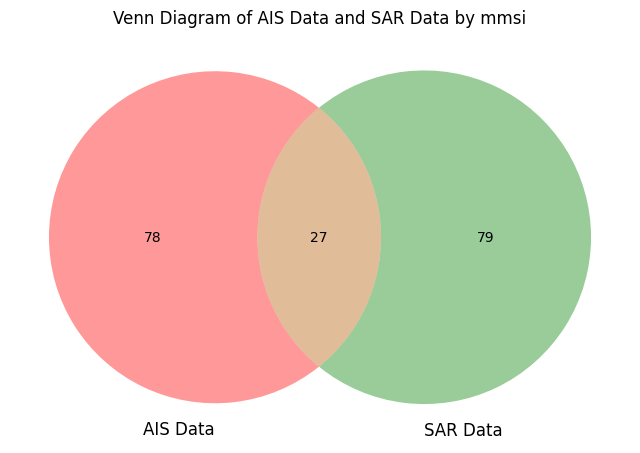

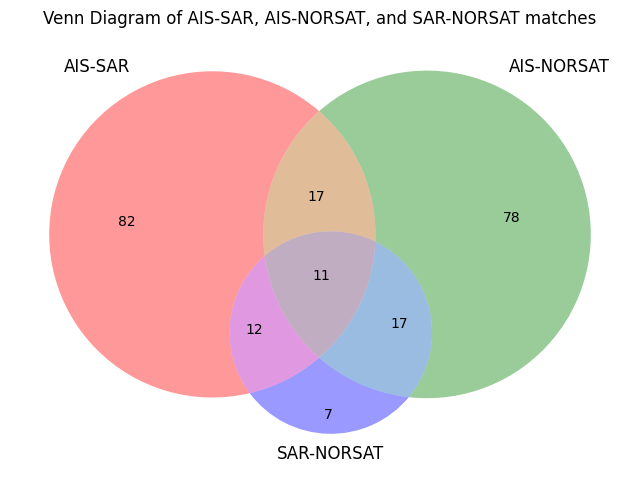

In [13]:
# VENN DIAGRAMS FUNCTIONS#
# Assuming df1 and df2 are your dataframes and 'mmsi' is the ID column
match_dataframes_and_venn(ais_sar['cnnm'], ais_norsat['cnnm'], 'mmsi', 'AIS Data', 'SAR Data')

dfs = [ais_sar,ais_norsat,sar_norsat]
model = 'cnnm'
id_columns = ['mmsi', 'sar_id', 'norsat_id']
labels = ['AIS-SAR', 'AIS-NORSAT', 'SAR-NORSAT']
create_venn_using_merge(dfs, model, id_columns, labels)


# TO-DO
- Triple matching function, through AIS mmsi numbers.
    - triple_match_df = sar_df.merge(norsat_df, on=['mmsi'])
    
- Venn diagram
    - By data types.
    - By matching models, for individual data types.

- Generate Map plots: <br>
    "f"MMSI: {mmsi_number_row}<br>{df1_index_column}: {index_row}<br>Distance: {distance_row}
    <br>Matching:"
    - SAR & AIS
    - SAR & RF
    - AIS & RF
    - SAR, AIS, & RF

- Create uncertainty chart or correlation value chart
    - Colorbar based on the angle of the uncertainty ellipse for a uncertainty plot

- Create a "true" matches dataset
- Assume a one data type to be a reference point

- Use an MLP to create a cost matrix. The data loader should be a 

# Notes:
- Beskriv med "egen fornuft" fejlkilder, for at begynder og overveje hvordan de kan mitigeres, fjernes eller accepteres.
- Real sar opløsning 22 meter, men oversampler for til 10x10

In [14]:
# MLP MATCHING ALGORITHM #
import torch
import pandas as pd
from scipy.optimize import linear_sum_assignment
from mlp import MyModel 

def hungarian(d):
    """
    Applies the Hungarian algorithm to the given distance matrix.

    Args:
        d (torch.Tensor): The distance matrix.

    Returns:
        torch.Tensor: Indices from the first and second sets that are optimally matched.
    """
    d_np = d.cpu().detach().numpy()  # Convert to NumPy array
    idx1, idx2 = linear_sum_assignment(d_np)  # Apply Hungarian algorithm
    return torch.tensor(idx1), torch.tensor(idx2)

def compute_distance_matrix_with_hungarian(model_path, df1, df2, input_dim=2, hidden_dim=256, output_dim=2, depth=5) -> torch.Tensor:
    """
    This function loads a pre-trained model, computes the distance matrix between two pandas DataFrames,
    and then finds the optimal matching using the Hungarian algorithm.

    Args:
        model_path (str): Path to the saved model file (e.g., 'model_epoch543.pth').
        df1 (pd.DataFrame): First DataFrame containing latitude and longitude columns.
        df2 (pd.DataFrame): Second DataFrame containing latitude and longitude columns.
        input_dim (int): Dimension of the input features (default: 2 for latitude and longitude).
        hidden_dim (int): Hidden dimension size of the model (default: 256).
        output_dim (int): Output dimension size of the model embeddings (default: 2).
        depth (int): Number of layers in the model (default: 5).

    Returns:
        (torch.Tensor, torch.Tensor): Indices of the optimal matching from df1 and df2.
    """

    # Step 1: Load the trained model
    model = MyModel(input_dim, hidden_dim, output_dim, depth)
    #model.load_state_dict(torch.load(model_path))

    # Load only the weights of the model (safer and future-proof)
    state_dict = torch.load(model_path, weights_only=True)

#    Load the state dict into your model
    model.load_state_dict(state_dict)
    model.eval()  # Set the model to evaluation mode

    # Step 2: Prepare the data
    points1 = torch.tensor(df1[['latitude', 'longitude']].values, dtype=torch.float32)
    points2 = torch.tensor(df2[['latitude', 'longitude']].values, dtype=torch.float32)

    # Step 3: Run inference
    with torch.no_grad():  # Disable gradient calculations
        emb1 = model(points1)
        emb2 = model(points2)

    # Step 4: Compute the distance (or similarity) matrix
    distance_matrix = torch.matmul(emb1, emb2.T)

    # Step 5: Apply the Hungarian algorithm to find the optimal matching
    idx1, idx2 = hungarian(distance_matrix)

    return idx1, idx2

def match_clusters_with_hungarian(df1, df2, ids, sources, eps=7, min_samples=2, model_path = r'C:\Users\abelt\OneDrive\Dokumenter\GitHub\Ship_datafusion\models\model_epoch.pth'):
    """
    Matches AIS and SAR data by applying DBSCAN clustering followed by the Hungarian algorithm.
    
    Parameters:
    - df1: DataFrame containing the AIS points.
    - df2: DataFrame containing the SAR points.
    - ids: List of unique identifiers for df1 and df2. Example: ['mmsi', 'sar_id'].
    - sources: List of sources for df1 and df2. Example: ['ais', 'sar'].
    - eps: The maximum distance between two samples for them to be considered as in the same neighborhood (for DBSCAN).
    - min_samples: The number of points required to form a cluster (for DBSCAN).
    - model_path: Path to the model for the Hungarian algorithm (optional).
    
    Returns:
    - matching_df: DataFrame containing matched points between df1 and df2.
    """

    # Ensure the DataFrames contain 'latitude' and 'longitude' columns        
    if not {'latitude', 'longitude'}.issubset(df1.columns) or not {'latitude', 'longitude'}.issubset(df2.columns):
        if {'int_latitude', 'int_longitude'}.issubset(df1.columns):
            df1.rename(columns={'int_latitude': 'latitude', 'int_longitude': 'longitude'}, inplace=True)
        elif {'int_latitude', 'int_longitude'}.issubset(df2.columns):
            df2.rename(columns={'int_latitude': 'latitude', 'int_longitude': 'longitude'}, inplace=True)
        else:
            raise ValueError("Input DataFrames must contain 'latitude' and 'longitude' columns.")
    
    # Apply DBSCAN clustering (using a placeholder function)
    clustered_df = cp.apply_dbscan_clustering(df1, df2, ids=ids, sources=sources, eps=eps, min_samples=min_samples)

    # Get unique cluster labels
    unique_clusters = clustered_df['cluster'].unique()

    # Initialize a list to store all matches across clusters
    all_matches = []

    for cluster in unique_clusters:
        if cluster == -1:
            # Skip noise points (cluster label -1 in DBSCAN)
            continue

        # Extract points within the current cluster
        cluster_data = clustered_df[clustered_df['cluster'] == cluster]
        cluster_df1 = cluster_data[cluster_data['source'] == sources[0]]  # AIS points
        cluster_df2 = cluster_data[cluster_data['source'] == sources[1]]  # SAR points

        # Ensure there are both df1 and df2 points in the cluster
        if len(cluster_df1) > 0 and len(cluster_df2) > 0:
            # Extract coordinates for df1 and df2 in the current cluster
            df1_coords = cluster_df1[['latitude', 'longitude']]
            df2_coords = cluster_df2[['latitude', 'longitude']]
            
            # Apply Hungarian algorithm to find optimal matches
            idx1, idx2 = compute_distance_matrix_with_hungarian(model_path, df1_coords, df2_coords)
            
            # Convert the tensors to numpy arrays or lists for indexing pandas DataFrames
            ship_indices = idx1.numpy()
            df2_indices = idx2.numpy()

            # Create matches for the current cluster
            for ship_idx, df2_idx in zip(ship_indices, df2_indices):
                
                # Extract match details from df1 and df2
                df1_match = cluster_df1.iloc[ship_idx]
                df2_match = cluster_df2.iloc[df2_idx]

                # Extract relevant columns
                df1_id = df1_match['id']  # e.g., 'mmsi'
                df1_lat = df1_match['latitude']
                df1_lon = df1_match['longitude']
                df2_id = df2_match['id']  # e.g., 'sar_id'
                df2_lat = df2_match['latitude']
                df2_lon = df2_match['longitude']
                
                # You can also add distance or other matching criteria if you have them
                # distance_km = cost_matrix[ship_idx, df2_idx]

                # Create a match record as a dictionary
                match = {
                    ids[0]: df1_id,  # e.g., 'mmsi'
                    'df1_lat': df1_lat,
                    'df1_lon': df1_lon,
                    ids[1]: df2_id,  # e.g., 'sar_id'
                    'df2_lat': df2_lat,
                    'df2_lon': df2_lon,
                    # Uncomment this if you calculate distance
                    # 'distance_km': distance_km
                }

                # Append the match to the list of all matches
                all_matches.append(match)

    # Convert the list of matches into a DataFrame
    return pd.DataFrame(all_matches)

In [15]:
# Call the matching function
matching_df = cma.match_clusters_with_hungarian(interpolated_ais_sar.copy(), filtered_sar_data.copy(), ['mmsi', 'sar_id'], ['ais', 'sar'], eps=7, min_samples=2)
matching_df_2 = cma.match_clusters_with_hungarian(interpolated_ais_norsat.copy(), norsat_data.copy(), ['mmsi', 'norsat_id'], ['ais', 'norsat'], eps=7, min_samples=2)

Estimated number of clusters: 241
Estimated number of noise points: 184
Estimated number of clusters: 235
Estimated number of noise points: 192


In [17]:
# model_path = r'C:\Users\abelt\OneDrive\Dokumenter\GitHub\Ship_datafusion\models\model_epoch.pth'
# idx1, idx2 = compute_distance_matrix_with_hungarian(model_path, interpolated_ais_sar, filtered_sar_data)
# # Convert the tensors to numpy arrays or lists for indexing pandas DataFrames
# idx1_np = idx1.numpy()
# idx2_np = idx2.numpy()

# # Use the indices to select rows from the DataFrames
# matched_df1_rows = interpolated_ais_sar.iloc[idx1_np]
# matched_df2_rows = filtered_sar_data.iloc[idx2_np]